In [1]:
import tensorflow as tf
import random
import os
import glob
import cv2
import numpy as np
import torch
import keras
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import *
from tensorflow.keras import models
from keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
from keras.models import save_model
from sklearn.model_selection import train_test_split
import h5py
import shutil
from lime import lime_image
from keras import callbacks

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
current_dir = os.getcwd()
data_folder = os.path.join(current_dir,"Data")

In [4]:
real_paths = glob.glob(os.path.join(data_folder,"Real","*mp4"))
fake_paths = glob.glob(os.path.join(data_folder,"Fake","*mp4"))

In [4]:
image_size=(256,256)
channels = 3

def video_frames(path,size,n_frames=10):
    
    
    filename = os.path.basename(path).split(".")[0]
    folder = path.replace(os.path.basename(path),"")
    
    capture = cv2.VideoCapture(path)
    frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    
    frames = []
    
    for i in range(n_frames):
        
        
        
        randomFrameNumber=random.randint(0, frame_count)
        frames.append(randomFrameNumber)
    
    
    #print(frames)
    
    for frame_num in frames:
        
        capture.set(cv2.CAP_PROP_POS_FRAMES,frame_num)
        ret, frame = capture.read()
        
        if not ret:
            break
            
            
        
        frame = cv2.resize(frame,size)
        frame = cv2.imwrite(folder + filename + "_" + str(frame_num) + ".jpg",frame)
        
    
    
    
    

In [18]:
real_images = [video_frames(path,image_size) for path in real_paths]
fake_images = [video_frames(path,image_size) for path in fake_paths]

In [44]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

In [60]:
def face_cropper(dir,size):
    
    for image in dir:
        
        filename = os.path.basename(image).split(".")[0]
        folder = image.replace(os.path.basename(image),"")
        
        img = cv2.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 4)
        
        if len(faces) > 0:
            
            for i,(x,y,w,h) in enumerate(faces):
                
                
                cv2.rectangle(img, (x, y), (x + w, y + h), (0, 256, 256), 2)
                face = img[y:y + h, x:x + w]
                face = cv2.resize(face,size)
                cv2.imwrite(folder + filename + "_" + f'face{i}.jpg', face)
        
        os.remove(image)



In [6]:
real_images = glob.glob(os.path.join(data_folder,"Real","*jpg"))
fake_images = glob.glob(os.path.join(data_folder,"Fake","*jpg"))

In [7]:
for i in range(len(fake_images) - len(real_images)):
    
    os.remove(fake_images[i])

In [70]:
face_cropper(real_images,image_size)
face_cropper(fake_images,image_size)

In [6]:
train_folder = os.path.join(os.path.join(current_dir,"Dataset"),"Train")
validation_folder = os.path.join(os.path.join(current_dir,"Dataset"),"Validation")

In [310]:
dataGenerator = ImageDataGenerator(horizontal_flip=True,rescale=1./255)
train_generator = dataGenerator.flow_from_directory(
    train_folder,target_size=(256,256),batch_size=16,class_mode="binary")
validation_generator = dataGenerator.flow_from_directory(
    validation_folder,target_size=(256,256),batch_size=16,class_mode="binary")

Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.


In [311]:
mobile_net = keras.applications.mobilenet.MobileNet(
    
    include_top = True,
    weights = None,
    classes=2,
    input_shape = (256,256,3),
    classifier_activation="sigmoid"
    
)


In [312]:
mobile_net.compile(optimizer ="adam", loss = tf.keras.losses.binary_crossentropy, metrics=["accuracy"])

In [314]:
mobile_net.summary()

Model: "mobilenet_1.00_256"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 128, 128, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 128, 128, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 128, 128, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 128, 128, 32)     128       
 ation)                                         

In [315]:
model = models.Sequential([
    
    layers.Rescaling(1./255, input_shape=(256, 256, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    
])
model.add(mobile_net)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [316]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 mobilenet_1.00_256 (Functio  (None, 2)                3230914   
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 2)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [317]:
model.compile(optimizer ="adam", loss = tf.keras.losses.binary_crossentropy, metrics=["accuracy"])

In [318]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True,
                                       verbose=1)
checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath=current_dir, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch', options=None)

lr_adjust=tf.keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.5, patience=1, verbose=0, mode="auto",
    min_delta=0.00001,  cooldown=0,  min_lr=0) 

In [319]:
EPOCHS = 100
history = model.fit(train_generator, epochs = EPOCHS, validation_data = validation_generator,callbacks =[earlystopping,lr_adjust,checkpoint])

Epoch 1/100
8751/8751 [==============================] - ETA: 0s - loss: 0.5348 - accuracy: 0.7321WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


8751/8751 [==============================] - 1672s 191ms/step - loss: 0.5348 - accuracy: 0.7321 - val_loss: 0.3584 - val_accuracy: 0.8632 - lr: 0.0010
Epoch 2/100
8751/8751 [==============================] - 1893s 216ms/step - loss: 0.2248 - accuracy: 0.9198 - val_loss: 0.3736 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 3/100
8751/8751 [==============================] - ETA: 0s - loss: 0.1128 - accuracy: 0.9611WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


8751/8751 [==============================] - 1906s 218ms/step - loss: 0.1128 - accuracy: 0.9611 - val_loss: 0.2091 - val_accuracy: 0.9159 - lr: 5.0000e-04
Epoch 4/100
8751/8751 [==============================] - ETA: 0s - loss: 0.0882 - accuracy: 0.9684WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


8751/8751 [==============================] - 1935s 221ms/step - loss: 0.0882 - accuracy: 0.9684 - val_loss: 0.1994 - val_accuracy: 0.9207 - lr: 5.0000e-04
Epoch 5/100
8751/8751 [==============================] - 2377s 272ms/step - loss: 0.0753 - accuracy: 0.9724 - val_loss: 0.4286 - val_accuracy: 0.8477 - lr: 5.0000e-04
Epoch 6/100
8751/8751 [==============================] - ETA: 0s - loss: 0.0587 - accuracy: 0.9788WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


8751/8751 [==============================] - 1877s 214ms/step - loss: 0.0587 - accuracy: 0.9788 - val_loss: 0.1095 - val_accuracy: 0.9590 - lr: 2.5000e-04
Epoch 7/100
8751/8751 [==============================] - 1499s 171ms/step - loss: 0.0544 - accuracy: 0.9803 - val_loss: 0.1269 - val_accuracy: 0.9536 - lr: 2.5000e-04
Epoch 8/100
8751/8751 [==============================] - ETA: 0s - loss: 0.0464 - accuracy: 0.9832WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


8751/8751 [==============================] - 1549s 177ms/step - loss: 0.0464 - accuracy: 0.9832 - val_loss: 0.0781 - val_accuracy: 0.9709 - lr: 1.2500e-04
Epoch 9/100
8751/8751 [==============================] - 1635s 187ms/step - loss: 0.0442 - accuracy: 0.9842 - val_loss: 0.0831 - val_accuracy: 0.9695 - lr: 1.2500e-04
Epoch 10/100
8751/8751 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.9855WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


8751/8751 [==============================] - 1952s 223ms/step - loss: 0.0397 - accuracy: 0.9855 - val_loss: 0.0740 - val_accuracy: 0.9740 - lr: 6.2500e-05
Epoch 11/100
8751/8751 [==============================] - ETA: 0s - loss: 0.0385 - accuracy: 0.9861WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


8751/8751 [==============================] - 1745s 199ms/step - loss: 0.0385 - accuracy: 0.9861 - val_loss: 0.0719 - val_accuracy: 0.9747 - lr: 6.2500e-05
Epoch 12/100
8751/8751 [==============================] - ETA: 0s - loss: 0.0371 - accuracy: 0.9866WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


8751/8751 [==============================] - 2348s 268ms/step - loss: 0.0371 - accuracy: 0.9866 - val_loss: 0.0694 - val_accuracy: 0.9744 - lr: 6.2500e-05
Epoch 13/100
8751/8751 [==============================] - 2131s 244ms/step - loss: 0.0364 - accuracy: 0.9867 - val_loss: 0.0744 - val_accuracy: 0.9727 - lr: 6.2500e-05
Epoch 14/100
8751/8751 [==============================] - 2890s 330ms/step - loss: 0.0342 - accuracy: 0.9879 - val_loss: 0.0696 - val_accuracy: 0.9755 - lr: 3.1250e-05
Epoch 15/100
8751/8751 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.9882WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


INFO:tensorflow:Assets written to: C:\Users\Tiago\Desktop\celeb_df\assets


8751/8751 [==============================] - 2366s 270ms/step - loss: 0.0333 - accuracy: 0.9882 - val_loss: 0.0666 - val_accuracy: 0.9766 - lr: 1.5625e-05
Epoch 16/100
8751/8751 [==============================] - 1369s 156ms/step - loss: 0.0329 - accuracy: 0.9880 - val_loss: 0.0670 - val_accuracy: 0.9768 - lr: 1.5625e-05
Epoch 17/100
8751/8751 [==============================] - 1351s 154ms/step - loss: 0.0324 - accuracy: 0.9883 - val_loss: 0.0673 - val_accuracy: 0.9772 - lr: 7.8125e-06
Epoch 18/100
8751/8751 [==============================] - 1354s 155ms/step - loss: 0.0320 - accuracy: 0.9885 - val_loss: 0.0673 - val_accuracy: 0.9767 - lr: 3.9063e-06
Epoch 19/100
8751/8751 [==============================] - 1354s 155ms/step - loss: 0.0317 - accuracy: 0.9889 - val_loss: 0.0673 - val_accuracy: 0.9775 - lr: 1.9531e-06
Epoch 20/100
8751/8751 [==============================] - 1354s 155ms/step - loss: 0.0317 - accuracy: 0.9888 - val_loss: 0.0691 - val_accuracy: 0.9761 - lr: 9.7656e-07
Epoch

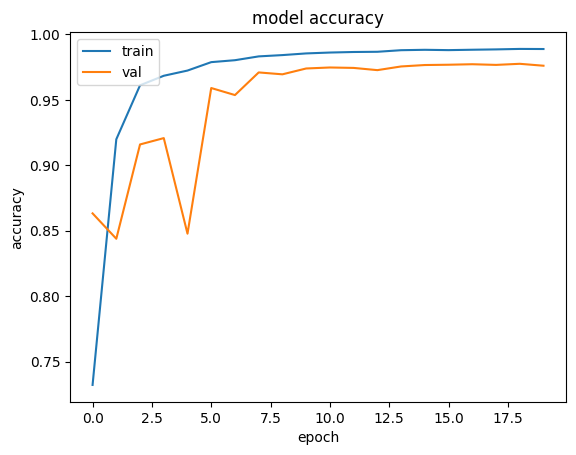

In [320]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [321]:
test_dir = os.path.join(os.path.join(current_dir,"Dataset"),"Test")
generator_test = dataGenerator.flow_from_directory(test_dir,target_size=(256,256),batch_size=1,class_mode="binary")

Found 10905 images belonging to 2 classes.


In [322]:
generator_test.class_indices

{'Fake': 0, 'Real': 1}

In [323]:
X, y = generator_test.next()

In [324]:
model.predict(X)[0][0]

1/1 [==============================] - 1s 501ms/step


0.7894806

In [325]:
int(y[0])

1

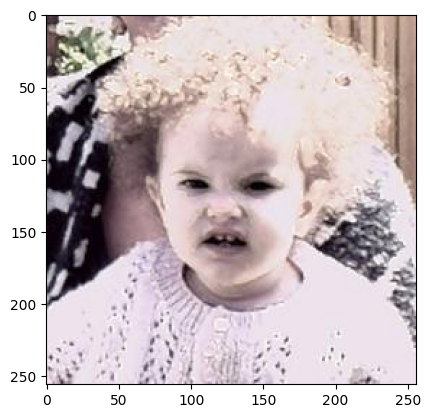

In [344]:
plt.imshow(((X)[0] * 255).astype("uint8"))

In [345]:
len(generator_test)

10905

In [346]:
true_Positive = []
true_Positive_pred = []

true_Negative = []
true_Negative_pred = []

false_Positive = []
false_Positive_pred = []

false_Negative = []
false_Negative_pred = []

for i in range(len(generator_test)):
    
    X,y = generator_test.next()
    pred = model.predict(X,verbose=0)[0][0]
    
    if round(pred) == y[0] and y[0] == 1:
        true_Positive.append(X)
        true_Positive_pred.append(pred)
        
    elif round(pred) == y[0] and y[0] == 0:
        true_Negative.append(X)
        true_Negative_pred.append(pred)
        
    elif y[0] == 0:
        false_Negative.append(X)
        false_Negative_pred.append(pred)
        
    else:
        false_Positive.append(X)
        false_Positive_pred.append(pred)
        

In [353]:
def plotter(images,preds):
    fig = plt.figure(figsize=(16,9))
    subset = np.random.randint(1, len(images)-1, 12)
    for i,j in enumerate(subset):
        fig.add_subplot(3,4,i+1)
        plt.imshow((np.squeeze(images[j] * 255).astype("uint8")))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show;
    return


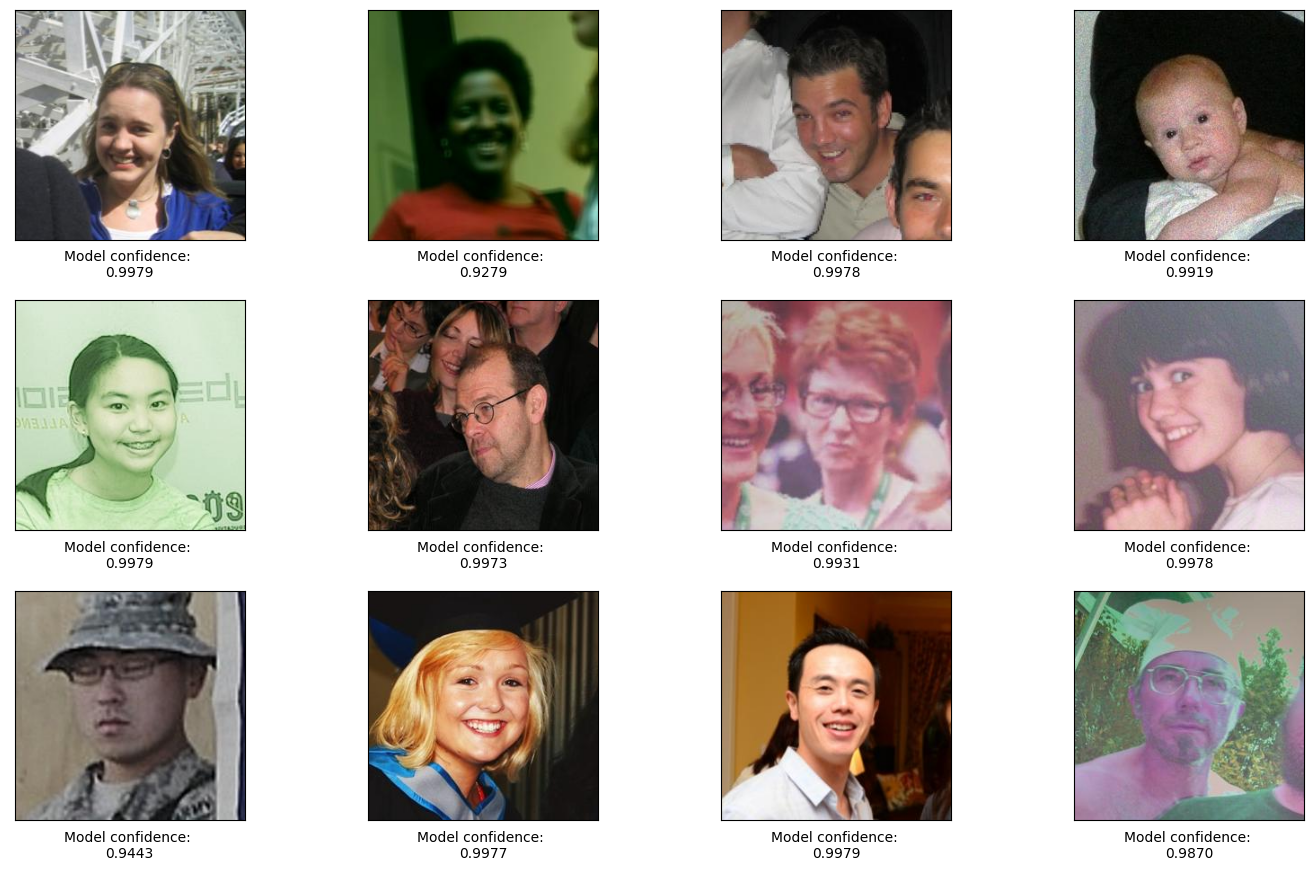

In [354]:
plotter(true_Positive,true_Positive_pred)

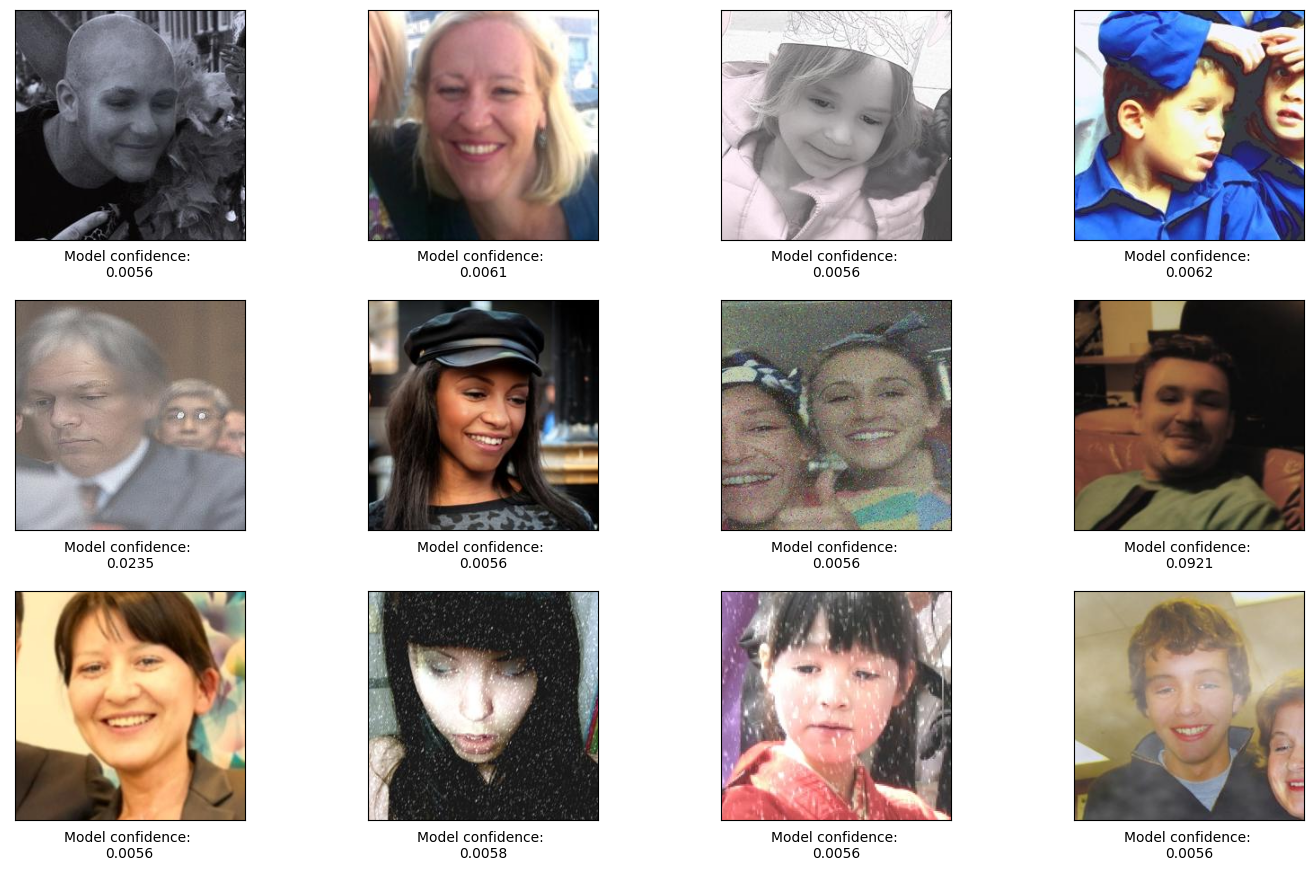

In [355]:
plotter(true_Negative,true_Negative_pred)

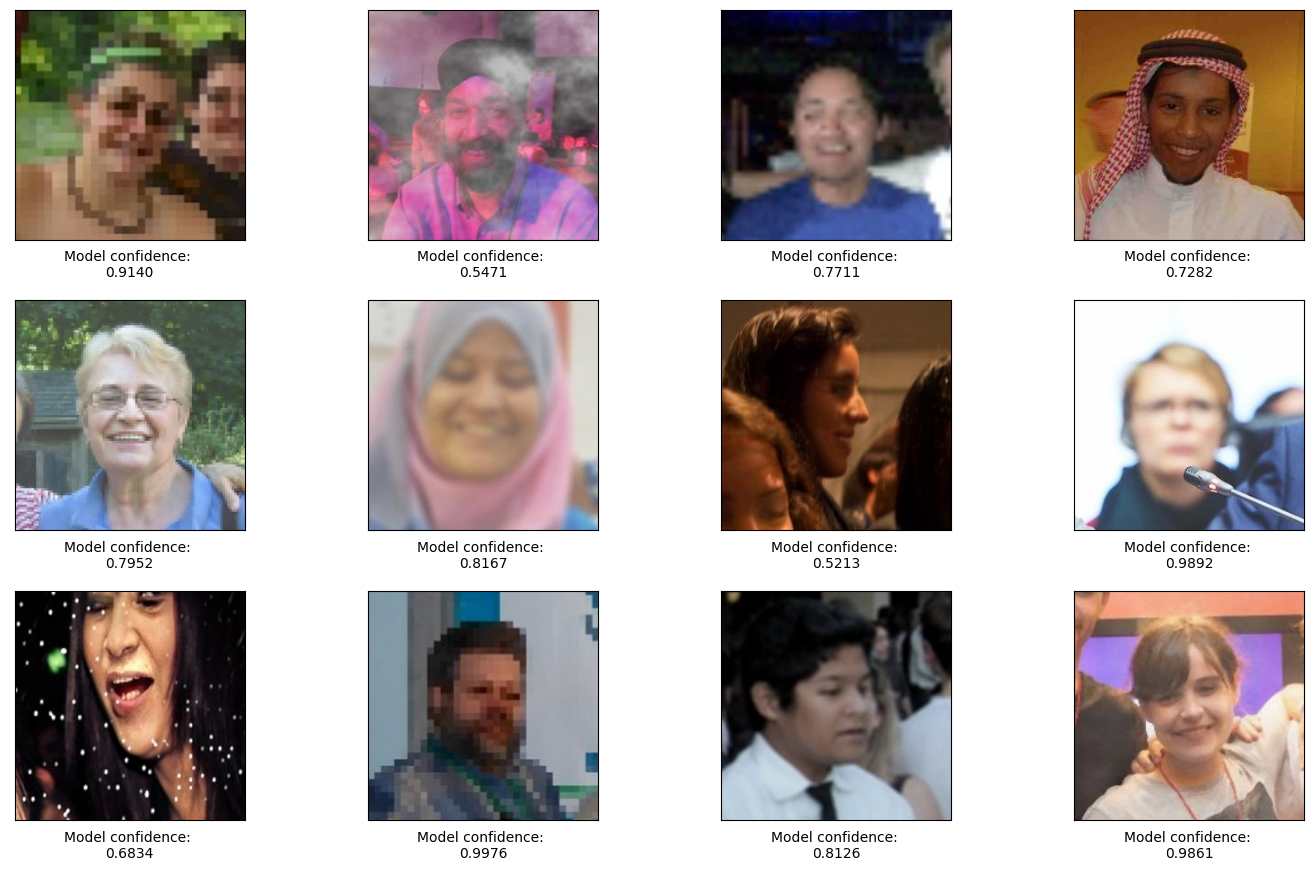

In [356]:
plotter(false_Negative,false_Negative_pred)

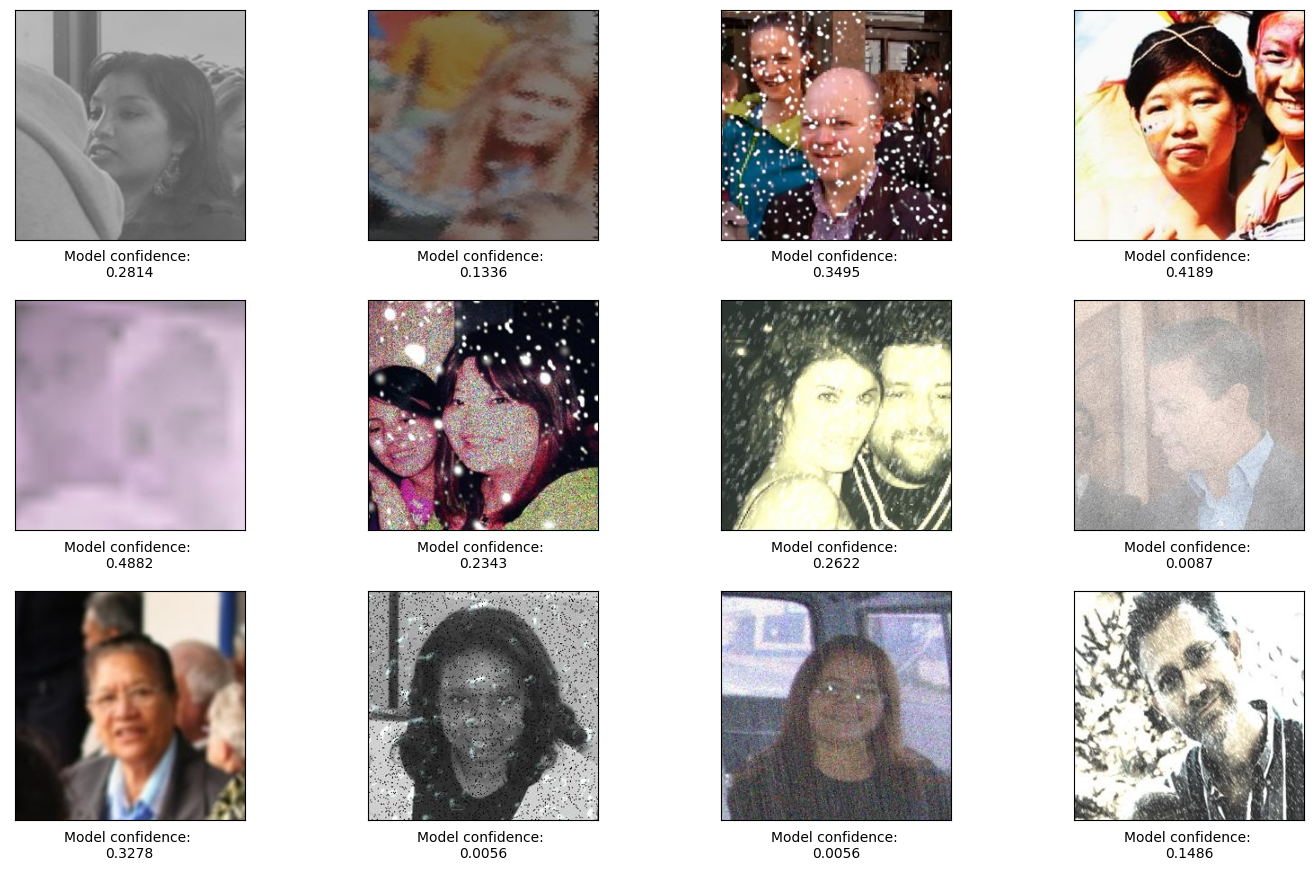

In [357]:
plotter(false_Positive,false_Positive_pred)

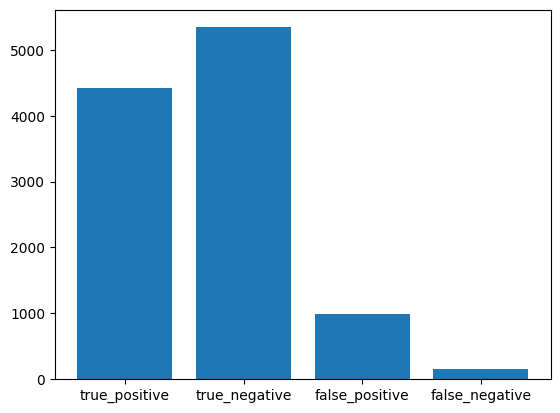

In [358]:
fig, ax = plt.subplots()

len_arr = [len(true_Positive),len(true_Negative),len(false_Positive),len(false_Negative)]
labels_arr = ["true_positive","true_negative","false_positive","false_negative"]

ax.bar(labels_arr, len_arr)
plt.show()

In [359]:
model.evaluate(generator_test)

10905/10905 [==============================] - 154s 14ms/step - loss: 0.3664 - accuracy: 0.8939


[0.3663773238658905, 0.8939018845558167]

In [360]:
model = tf.keras.models.load_model(current_dir)


In [361]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 mobilenet_1.00_256 (Functio  (None, 2)                3230914   
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 2)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                

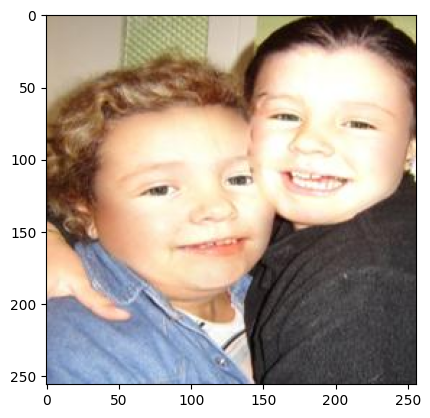

In [362]:
X, y = generator_test.next()
plt.imshow((np.squeeze(X) * 255).astype("uint8"))

In [363]:
model.predict(X)[0][0]

1/1 [==============================] - 1s 620ms/step


0.00557746

In [364]:
int(y[0])

0

In [365]:
def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_pad(image, target_height=256, target_width=256)
  return image

In [366]:
img = read_image(os.path.join(current_dir,"fake_15.jpg"))


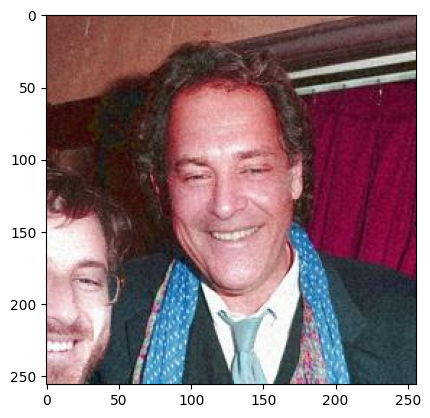

In [367]:
plt.imshow(img)


In [368]:
model(tf.expand_dims(img,0))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00557834]], dtype=float32)>

In [375]:
baseline = tf.zeros(shape=(256,256,3))


In [376]:
baseline

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)>

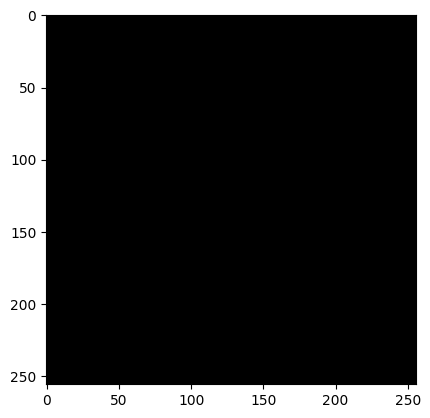

In [377]:
plt.imshow(baseline)

In [378]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

In [379]:
def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

In [380]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=img,
    alphas=alphas)


In [381]:
fig = plt.figure(figsize=(20, 20))


<Figure size 2000x2000 with 0 Axes>

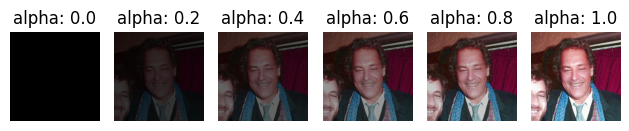

In [382]:

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout();


In [383]:
def compute_gradients(images):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
    probs = tf.math.sigmoid(logits)
  return tape.gradient(probs, images)


In [384]:
path_gradients = compute_gradients(
    images=interpolated_images)


In [385]:
pred = model(interpolated_images)
pred_proba = tf.math.sigmoid(pred)


Text(0.5, 0, 'alpha')

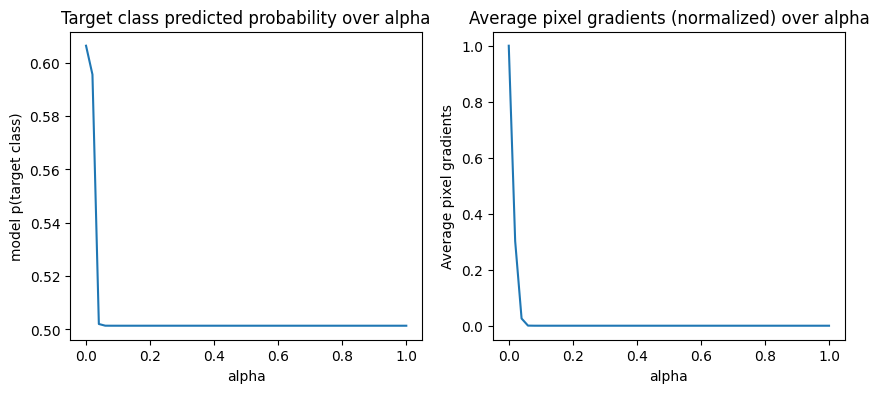

In [386]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')


ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')



In [387]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

In [388]:
ig = integral_approximation(
    gradients=path_gradients)


In [389]:
ig.shape

TensorShape([256, 256, 3])

In [390]:
def integrated_gradients(baseline,
                         image,
                         m_steps=50,
                         batch_size=32):
  # Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Collect gradients.    
  gradient_batches = []

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    gradient_batch = one_batch(baseline, image, alpha_batch)
    gradient_batches.append(gradient_batch)

  # Stack path gradients together row-wise into single tensor.
  total_gradients = tf.stack(gradient_batch)

  # Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [391]:
@tf.function
def one_batch(baseline, image, alpha_batch):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch)
    return gradient_batch

In [392]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=img,
                                       m_steps=240)


In [393]:
ig_attributions.shape

TensorShape([256, 256, 3])

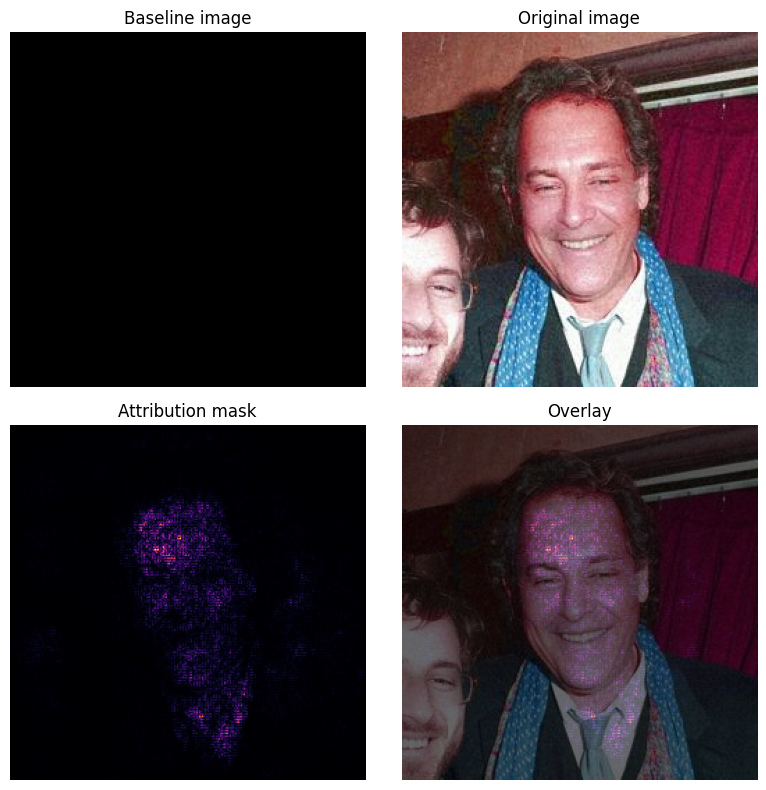

In [394]:
_ = plot_img_attributions(image=img,
                          baseline=baseline,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)
